## Setting up the Environment


In [1]:
# Подключение к Гугл Диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ПРоверить текущую директорию
import os
os.chdir("/content/drive/My Drive/")
!ls

 16540376.xlsx
 2_5226819210314778928.epub
 cache_dir
'Colab Notebooks'
'CV -Shokhrukh.doc'
 data
 Kaggle
 kaggle.json
'ML - MIPT fall 2020'
 MRI-Fast-RCNN
 outputs
 Presentation
 runs
 sample_submission.csv
'sub_7 - BERT (3 копий фейков).csv'
 test_data.csv.zip
 Timeline.xlsx
 train_data.csv.zip
'VaR - примеры расчета'
 АША.pdf
 ДИПЛОМ
'Диплом_Абдурахманов 2.pdf'
'Диссертация нейросети тпу.pdf'
'Заявление на социальное пособие-1.rtf.gdoc'
'Заявление на социальное пособие.rtf.gdoc'
'ЗШ - ИТМО'
'кантарович авррядов.pdf'
 Книги
'Книги по программированию'
'ЛАБОРАТОРНЫЙ ПРАКТИКУМ.doc'
'Магистратура 1 семестр'
'Материалы Суда'
'Москва - кванториум'
'Москва фото'
'Олимпиада БД - демонстрационные задач'
'Поступление в ВУЗы'
 Прайс-Лист.docx
'Производственная практика'
 работа
'Ссылки на статьи с конкретными примерами.gdoc'
'Текст Диплома'
'УПРАВЛЕНИЕ ИНВЕСТИЦИОННЫМ ПОРТФЕЛЕМ.pdf'
 Учеба
 Фотографии
'Хакатоны и сорвенования'
'Цифровой прорыв'
'Цифровой прорыв 2-4 октября'


In [ ]:
from IPython.display import clear_output
!pip install imutils

from keras.applications.vgg16 import VGG16,preprocess_input

In [4]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

import math
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from random import shuffle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input


import sys
import random
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras

## Data Import and preprocessing

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
TRAIN_DIR = '/content/drive/My Drive/Хакатоны и соревнования/mri/data/train/'
TEST_DIR = '/content/drive/My Drive/Хакатоны и соревнования/mri/data/test/'
VAL_DIR = '/content/drive/My Drive/Хакатоны и соревнования/mri/data/val/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 4/4 [12:03<00:00, 180.86s/it]


3010 images loaded from /content/drive/My Drive/Хакатоны и соревнования/mri/data/train/ directory.


100%|██████████| 4/4 [01:34<00:00, 23.61s/it]


379 images loaded from /content/drive/My Drive/Хакатоны и соревнования/mri/data/test/ directory.


100%|██████████| 4/4 [01:33<00:00, 23.37s/it]

375 images loaded from /content/drive/My Drive/Хакатоны и соревнования/mri/data/val/ directory.


In [10]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [11]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

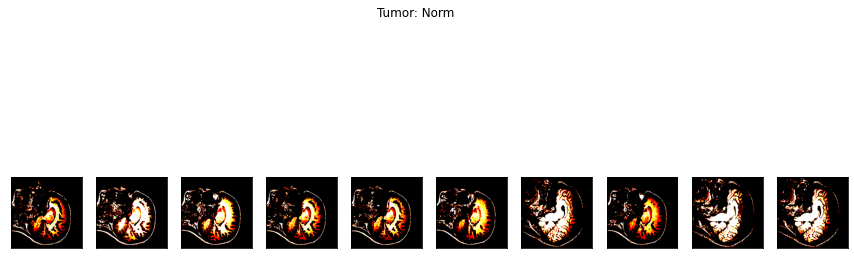

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

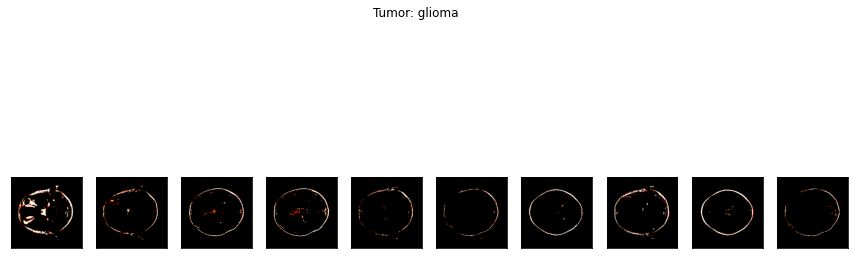

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

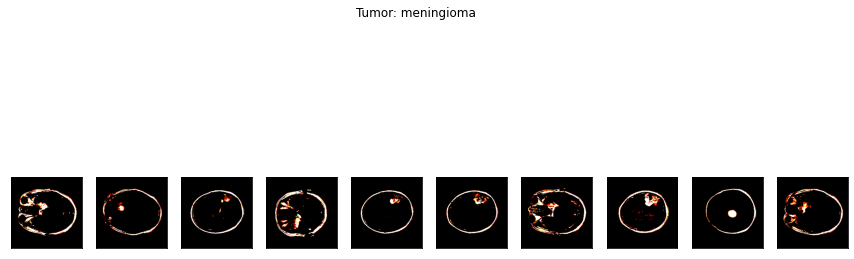

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

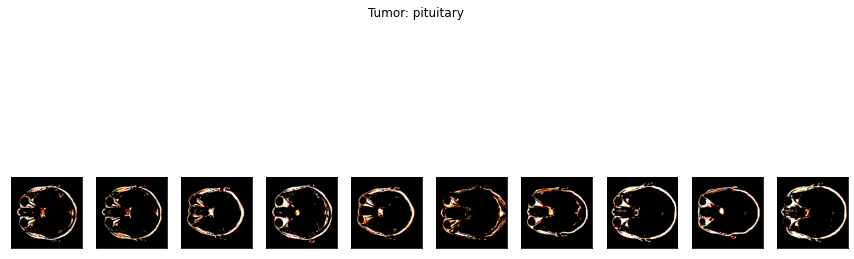

In [12]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()
        
plot_samples(X_train_prep, y_train, labels, 10)

In [13]:
# Создаем генератор изображений
datagen = ImageDataGenerator(rescale=1. / 255)
img_width, img_height = 224, 224

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical')

Found 3010 images belonging to 4 classes.
Found 375 images belonging to 4 classes.
Found 379 images belonging to 4 classes.


# CNN Model

## Transfer learning

In [ ]:
# Tensorflow обновился до 2.0, здесь присходит откат на версию 1.14
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

In [17]:
# load base model
vgg16_weight_path = '/content/drive/My Drive/Хакатоны и соревнования/mri/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

ModuleNotFoundError: ignored

# VGG-16

553467904/553467096 [==============================] - 40s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


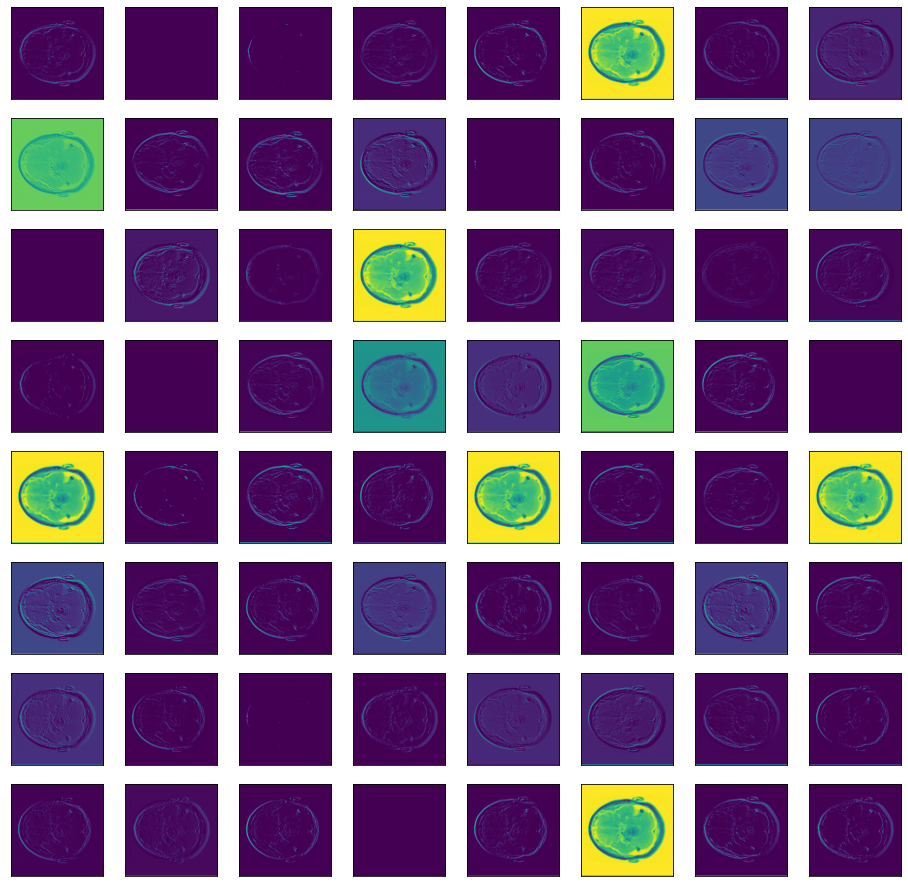

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot 
from numpy import expand_dims


f = plt.figure(figsize=(16,16))
# load the modelf = plt.figure(figsize=(10,3))
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
NUM_CLASSES = 3

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='softmax'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['categorical_accuracy']
)
vgg16.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 75267     
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims

# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		plt.figure(figsize=(64,64))
		for _ in range(square):
           

			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure

        
	plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import time

start = time.time()

vgg16_history = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
50/50 [==============================] - 1089s 22s/step - loss: 0.9125 - acc: 0.6244 - val_loss: 0.4971 - val_acc: 0.7607
Epoch 2/5
50/50 [==============================] - 1116s 22s/step - loss: 0.4995 - acc: 0.7760 - val_loss: 0.3994 - val_acc: 0.8426
Epoch 3/5
50/50 [==============================] - 1082s 22s/step - loss: 0.3878 - acc: 0.8329 - val_loss: 0.3676 - val_acc: 0.8459
Epoch 4/5
50/50 [==============================] - 1040s 21s/step - loss: 0.3109 - acc: 0.8645 - val_loss: 0.3376 - val_acc: 0.8525
Epoch 5/5
50/50 [==============================] - 1015s 20s/step - loss: 0.3163 - acc: 0.8687 - val_loss: 0.4126 - val_acc: 0.8328
5342.637012004852


# Calculate Metric

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

NameError: ignored

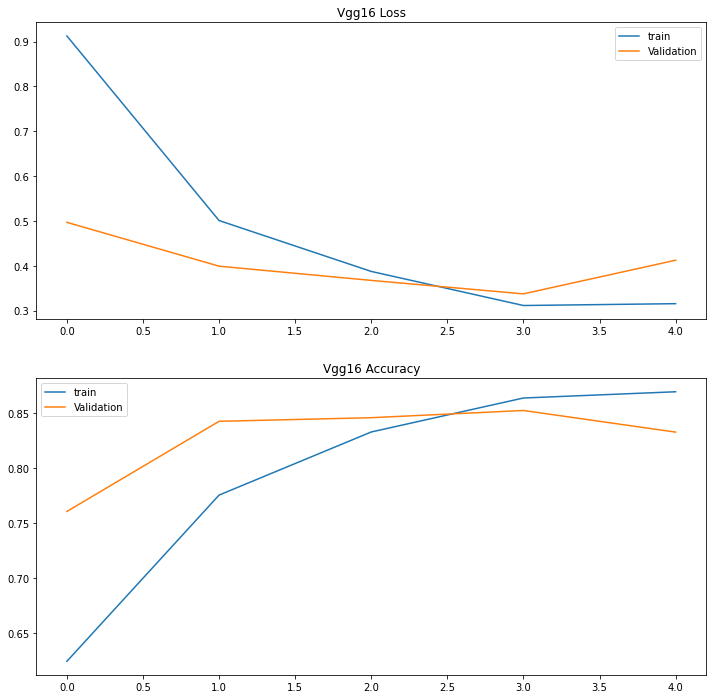

In [ ]:
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(vgg16_history.history['loss'], label='train')
pyplot.plot(vgg16_history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(vgg16_history.history['acc'], label='train')
pyplot.plot(vgg16_history.history['val_acc'], label='Validation')
pyplot.legend()
pyplot.show()

In [ ]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

NameError: ignored